In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import konlpy
import sentencepiece as spm
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
os.chdir("data")

In [3]:
train_path = os.getcwd() + '/korean-english-park.train.ko'
print(train_path)

C:\Users\양자\Desktop\Hun_Works\AIFFEL_quest_rs\GoingDeeper\GD01\data/korean-english-park.train.ko


### SentencePiece 학습용 한국어 데이터 불러오기

In [4]:
with open(train_path, "r", encoding='utf-8') as f:
    raw = f.read().splitlines()
    
print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


### 단어 집합 조정

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


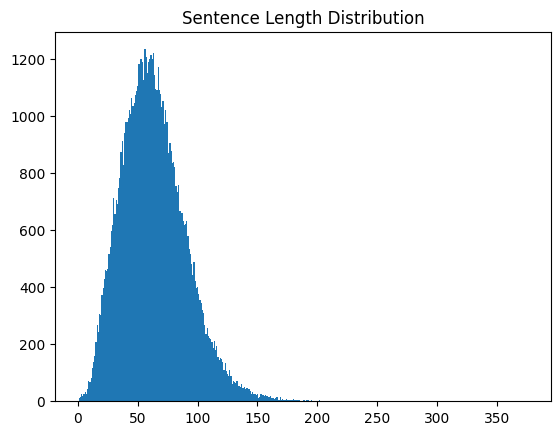

In [5]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
max_len = 150
min_len = 5

temp = [s for s in cleaned_corpus if len(s) < min_len]
print(len(temp))

temp = [s for s in cleaned_corpus if len(s) > max_len]
print(len(temp))

54
463


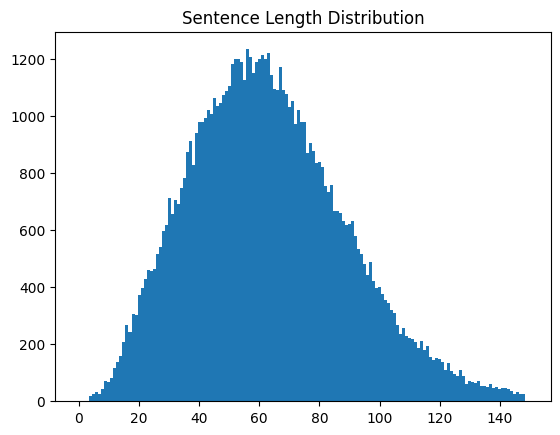

In [7]:
max_len = 150
min_len = 5

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### UNIGRAM, BPE 나누어 SentencePiece 모델 형성

In [8]:
# 인코딩 이슈인지 한글 이름이 경로에 있지 말 것 .. 열받는다 
temp_file = "C:/datasets_temp/korean-english-park.train.ko.temp"

# Parameter 1: Vocab size
vocab_size = 15000

with open(temp_file, 'w', encoding='utf-8') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

# Parameter 2: --model_type = unigram, or bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram --vocab_size={} --model_type=unigram'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)

### 예시

In [9]:
s_uni = spm.SentencePieceProcessor()
s_uni.Load('korean_spm_unigram.model')

s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('korean_spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs_uni = s_uni.EncodeAsIds('아버지가방에들어가신다.')
tokensIDs_bpe = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print("unigram 기반 SP모델:", tokensIDs_uni)
print("BPE 기반 SP모델:", tokensIDs_bpe)

# SentencePiece를 활용한 sentence -> encoded pieces
print("unigram 기반 SP모델:", s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))
print("BPE 기반 SP모델:", s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print("unigram 기반 SP모델:", s_uni.DecodeIds(tokensIDs_uni))
print("BPE 기반 SP모델:", s_bpe.DecodeIds(tokensIDs_bpe))

unigram 기반 SP모델: [1104, 11, 575, 9, 3220, 11, 299, 38, 3]
BPE 기반 SP모델: [7655, 6615, 13709, 2644, 13781, 13684, 13686]
unigram 기반 SP모델: ['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
BPE 기반 SP모델: ['▁아버지가', '방에', '들', '어가', '신', '다', '.']
unigram 기반 SP모델: 아버지가방에들어가신다.
BPE 기반 SP모델: 아버지가방에들어가신다.


In [10]:
def sp_tokenize(s, corpus, model_type): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
    
    if model_type == 'bpe':
        with open("./korean_spm_bpe.vocab", 'r', encoding='utf-8') as f:
            vocab = f.readlines()
    elif model_type == 'unigram':
        with open("./korean_spm_unigram.vocab", 'r', encoding='utf-8') as f:
            vocab = f.readlines()
    else:
        print("잘못된 model type")
        return None, None, None

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    seq_len = [len(s) for s in tensor]
    maxlen = int(np.percentile(seq_len,80))
    print('padding length: ', maxlen)
                               
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=maxlen, padding='pre')

    return tensor, word_index, index_word

## 네이버 영화리뷰 감성분석

### 한국어 데이터 불러오기

In [11]:
train_data_path = './ratings_train.txt'
test_data_path = './ratings_test.txt'

train_data = open(train_data_path, 'r', encoding = 'utf-8')
test_data = open(test_data_path, 'r', encoding = 'utf-8')

train_data_list = train_data.readlines()
test_data_list = test_data.readlines()

In [12]:
train_data_list[:4]

['id\tdocument\tlabel\n',
 '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0\n',
 '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t0\n',
 '10265843\t너무재밓었다그래서보는것을추천한다\t1\n']

In [13]:
test_data_list[:4]

['id\tdocument\tlabel\n',
 '6270596\t굳 ㅋ\t1\n',
 '9274899\tGDNTOPCLASSINTHECLUB\t0\n',
 '8544678\t뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아\t0\n']

### 레이블, 텍스트 분리

In [14]:
def parse_data(data_lines):
    parsed_data = []
    for line in data_lines[1:]:
        parts = line.strip().split("\t")
        if len(parts) < 3:
            continue  # 데이터 형식에 문제가 있는 경우 건너뜁니다.
        # parts[0]: id, parts[1]: document, parts[2]: label
        document = parts[1]
        try:
            label = int(parts[2])
        except ValueError:
            continue  # label 변환에 실패하면 해당 줄 건너뛰기
        parsed_data.append((document, label))
    return parsed_data

parsed_train_data = parse_data(train_data_list)
parsed_test_data = parse_data(test_data_list)

### 불용어 제거

In [15]:
stopwords_path = './stopwords.txt'
stopwords_data = open(stopwords_path, 'r', encoding = 'utf-8')
stopwords = stopwords_data.readlines()

In [16]:
stopwords = [word.strip() for word in stopwords]

In [17]:
stopwords[:5]

['가', '가까스로', '가령', '각', '각각']

In [18]:
parsed_train_data[:3]

[('아 더빙.. 진짜 짜증나네요 목소리', 0),
 ('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', 0),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [19]:
parsed_test_data[:3]

[('굳 ㅋ', 1),
 ('GDNTOPCLASSINTHECLUB', 0),
 ('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', 0)]

In [20]:
len(parsed_train_data)

150000

In [21]:
len(parsed_test_data)

50000

In [22]:
train_sentences = []
for sentence, label in parsed_train_data:
    words = sentence.split()
    filtered_sentence = " ".join([word for word in words if word not in stopwords])
    train_sentences.append(filtered_sentence)
    
train_labels = [label for sentence, label in parsed_train_data]

In [23]:
print(train_sentences[:3])
print(train_labels[:3])

['더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다']
[0, 0, 1]


In [24]:
parsed_test_data[:3]

[('굳 ㅋ', 1),
 ('GDNTOPCLASSINTHECLUB', 0),
 ('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', 0)]

In [25]:
### 테스트 데이터도 전처리
test_sentences = []
for sentence, label in parsed_test_data:
    words = sentence.split()
    filtered_sentence = " ".join([word for word in words if word not in stopwords])
    test_sentences.append(filtered_sentence)
    
test_labels = [label for doc, label in parsed_test_data]

In [26]:
print(test_sentences[:3])
print(test_labels[:3])

['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아']
[1, 0, 0]


### 인코딩 하기

In [27]:
s_uni = spm.SentencePieceProcessor()
s_uni.Load('korean_spm_unigram.model')

s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('korean_spm_bpe.model')

True

In [28]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize(s_uni, train_sentences, "unigram")
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize(s_bpe, train_sentences, "bpe")

padding length:  30
padding length:  27


In [29]:
### 테스트에 대해서도 똑같이 해주기

X_test_uni, _, _ = sp_tokenize(s_uni, test_sentences, "unigram")
X_test_bpe, _, _ = sp_tokenize(s_bpe, test_sentences, "bpe")

padding length:  30
padding length:  27


### Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

train_labels = np.array(train_labels)

X_train_uni, X_val_uni, y_train_uni, y_val_uni = train_test_split(tensor_uni,
                                                              train_labels,
                                                              test_size=0.2,
                                                              random_state=42)

X_train_bpe, X_val_bpe, y_train_bpe, y_val_bpe = train_test_split(tensor_bpe,
                                                              train_labels,
                                                              test_size=0.2,
                                                              random_state=42)

In [31]:
print("X_train_uni 타입:", type(X_train_uni))
print("y_train_uni 타입:", type(y_train_uni))
print("y_train_uni 샘플:", y_train_uni[:3])

X_train_uni 타입: <class 'numpy.ndarray'>
y_train_uni 타입: <class 'numpy.ndarray'>
y_train_uni 샘플: [0 1 0]


### 신경망 모델 형성하기

In [124]:
print("vocab size: ", vocab_size)
embedding_dim = 128
print("embedding_dim:", embedding_dim)

vocab size:  15000
embedding_dim: 128


In [131]:
model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(8, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(4, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1920000   
                                                                 
 lstm_5 (LSTM)               (None, 8)                 4384      
                                                                 
 batch_normalization_5 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dropout_119 (Dropout)       (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                      

### Callbacks

In [132]:
es = EarlyStopping(monitor='val_loss',
                   patience=3,
                   restore_best_weights=True,
                  )
                   
mc = ModelCheckpoint(filepath='./checkpoint.keras',
                     monitor='val_loss',
                     save_best_only=True,
                    )

callbacks = [es, mc]

### 예측하기

In [133]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

epochs=15
history_uni = model.fit(X_train_uni, y_train_uni,
                        epochs=epochs,
                        batch_size=128,
                        callbacks=callbacks,
                        validation_data=(X_val_uni, y_val_uni))

Epoch 1/15
938/938 [==============================] - 12s 11ms/step - loss: 0.4965 - accuracy: 0.7856 - val_loss: 0.4229 - val_accuracy: 0.8128
Epoch 2/15
938/938 [==============================] - 10s 10ms/step - loss: 0.4009 - accuracy: 0.8322 - val_loss: 0.3965 - val_accuracy: 0.8278
Epoch 3/15
938/938 [==============================] - 11s 11ms/step - loss: 0.3665 - accuracy: 0.8505 - val_loss: 0.4114 - val_accuracy: 0.8206
Epoch 4/15
938/938 [==============================] - 10s 11ms/step - loss: 0.3384 - accuracy: 0.8636 - val_loss: 0.3951 - val_accuracy: 0.8314
Epoch 5/15
938/938 [==============================] - 10s 11ms/step - loss: 0.3129 - accuracy: 0.8783 - val_loss: 0.3917 - val_accuracy: 0.8342
Epoch 6/15
938/938 [==============================] - 11s 11ms/step - loss: 0.2927 - accuracy: 0.8861 - val_loss: 0.4229 - val_accuracy: 0.8271
Epoch 7/15
938/938 [==============================] - 11s 12ms/step - loss: 0.2719 - accuracy: 0.8970 - val_loss: 0.4197 - val_accuracy:

1563/1563 [==============================] - 6s 4ms/step
Accuracy:  0.83008
Classification Rep: 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     24827
           1       0.83      0.83      0.83     25173

    accuracy                           0.83     50000
   macro avg       0.83      0.83      0.83     50000
weighted avg       0.83      0.83      0.83     50000



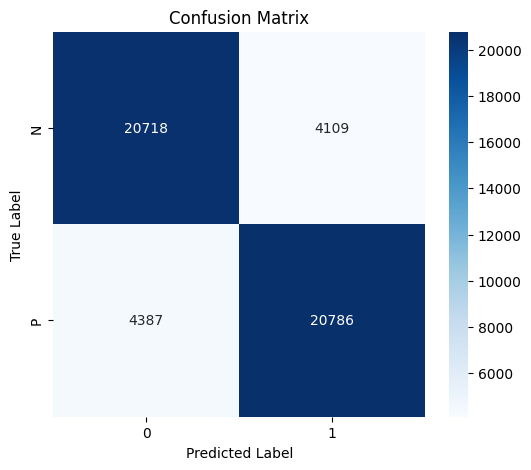

In [134]:
uni_predict = model.predict(X_test_uni)
uni_predict = (uni_predict > 0.5).astype(int).squeeze()
print("Accuracy: ", accuracy_score(test_labels, uni_predict))
print("Classification Rep: \n", classification_report(test_labels, uni_predict))

cm_uni = confusion_matrix(test_labels, uni_predict)
# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm_uni, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['N', 'P'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [129]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

epochs=15
history_bpe = model.fit(X_train_bpe, y_train_bpe,
                        epochs=15,
                        batch_size=128,
                        callbacks=callbacks,
                        validation_data=(X_val_uni, y_val_uni))

Epoch 1/15
938/938 [==============================] - 12s 11ms/step - loss: 0.4630 - accuracy: 0.7858 - val_loss: 0.7866 - val_accuracy: 0.5427
Epoch 2/15
938/938 [==============================] - 10s 11ms/step - loss: 0.3610 - accuracy: 0.8447 - val_loss: 0.8198 - val_accuracy: 0.5497
Epoch 3/15
938/938 [==============================] - 10s 11ms/step - loss: 0.3207 - accuracy: 0.8660 - val_loss: 0.9118 - val_accuracy: 0.5356
Epoch 4/15
938/938 [==============================] - 10s 11ms/step - loss: 0.2853 - accuracy: 0.8847 - val_loss: 1.1237 - val_accuracy: 0.5362


1563/1563 [==============================] - 5s 3ms/step
Accuracy:  0.81838
Classification Rep: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83     24827
           1       0.86      0.77      0.81     25173

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000



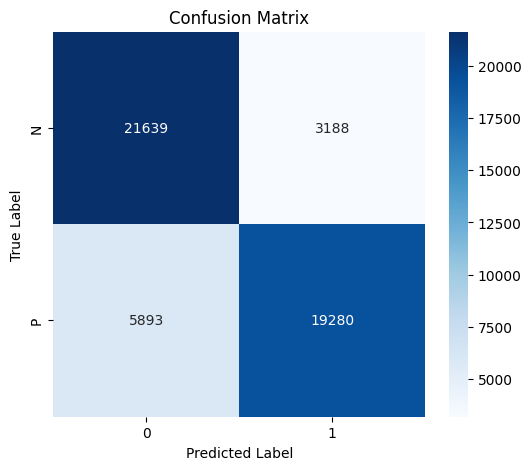

In [130]:
bpe_predict = model.predict(X_test_bpe)
bpe_predict = (bpe_predict > 0.5).astype(int).squeeze()
print("Accuracy: ", accuracy_score(test_labels, bpe_predict))
print("Classification Rep: \n", classification_report(test_labels, bpe_predict))

cm_bpe = confusion_matrix(test_labels, bpe_predict)
# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm_bpe, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['N', 'P'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 시도 1: UNIGRAM vs BPE

### SentencePiece Parameter: UNIGRAM vs BPE
1. Vocab size = 15000
2. Padding length = 길이가 짧은 80퍼센트 이후는 truncate ~ around 30

### Model Hyperparameter: LSTM
    model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(32, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(1, activation='sigmoid'),
    ])
 
Embedding dim = 128, (~ 128^2 ~ 15000) 
Batch size = 128


## UNIGRAM test acc: 0.831
## BPE test acc: 0.820


# 시도 2: UNIGRAM vs BPE

### SentencePiece Parameter:
1. Vocab size = 25000로 변경

## UNIGRAM test acc: 0.824
## BPE test acc: 0.832

둘 다 오버피팅이 빠르게 일어났음
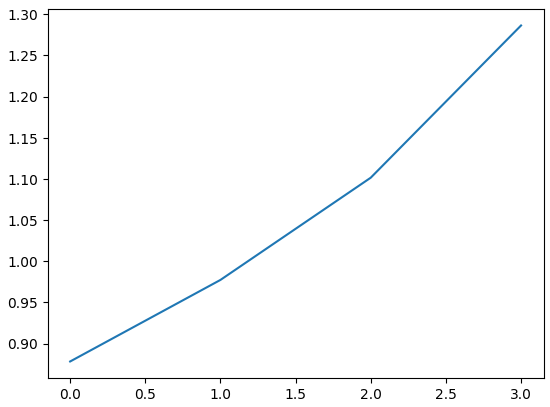

# 시도 3: 시도 1에서 과적합 방지

### SentencePiece Parameter:
1. Vocab size = 15000

### Model Hyperparameter: LSTM
    model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(16, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(8, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dense(1, activation='sigmoid'),
    ])

변경점:  
LSTM neuron 32 &rightarrow; 16,  
FFN neuron 16 &rightarrow; 8

## UNIGRAM test acc: 0.827
## BPE test acc: 0.817

여전히 오버피팅이 빠르게 일어남.

# 시도 4: 시도 3에서 모델 더 경량화

### SentencePiece Parameter:
1. Vocab size = 15000

### Model Hyperparameter: LSTM
    model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(16, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(8, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dense(1, activation='sigmoid'),
    ])

변경점:  
LSTM neuron 16 &rightarrow; 8,  
FFN neuron 8 &rightarrow; 4

## UNIGRAM test acc: 0.83

오버피팅은 언제 일어나는가?

이론상 모델이 임베딩을 제외하고 히든 레이어가 퍼셉트론에 가까워 질 경우 언더피팅으로의 수렴은 자명한 사실일텐데.

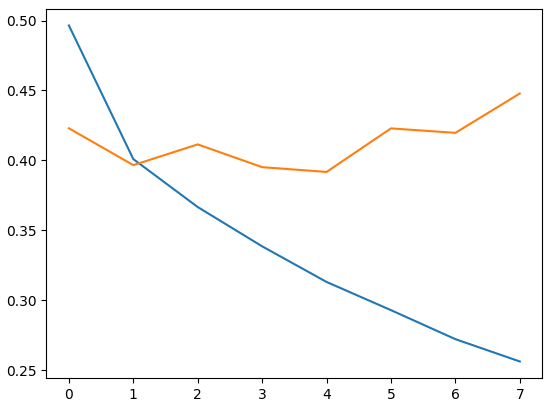

# 시도 5. 토크나이저 변경하기

시도 3에서 Neural network는 고정하고 토크나이저를 Okt로 변경

### Test acc : 0.84

In [102]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

In [98]:
Okt

konlpy.tag._okt.Okt

In [99]:
okt = Okt()

def okt_tokenize(sentences):
    return [" ".join(okt.morphs(sentence)) for sentence in sentences]

In [ ]:
train_sentences_okt = okt_tokenize(train_sentences)
test_sentences_okt = okt_tokenize(test_sentences)

In [104]:
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences_okt)

In [108]:
X_train = tokenizer.texts_to_sequences(train_sentences_okt)
X_test = tokenizer.texts_to_sequences(test_sentences_okt)

maxlen = 30

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding="pre", maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding="pre", maxlen=maxlen)
y_train = np.array(train_labels)
y_test = np.array(test_labels)
                  
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)     

In [109]:
model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(16, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(8, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1920000   
                                                                 
 lstm_3 (LSTM)               (None, 16)                9280      
                                                                 
 batch_normalization_3 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_117 (Dropout)       (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                      

In [110]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

In [111]:
history_okt = model.fit(
    X_train, y_train,
    epochs=10, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[es, mc]
)

Epoch 1/10
938/938 [==============================] - 14s 13ms/step - loss: 0.4632 - accuracy: 0.8115 - val_loss: 0.4517 - val_accuracy: 0.7887
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 0.3333 - accuracy: 0.8597 - val_loss: 0.3962 - val_accuracy: 0.8287
Epoch 3/10
938/938 [==============================] - 12s 12ms/step - loss: 0.3009 - accuracy: 0.8734 - val_loss: 0.3619 - val_accuracy: 0.8441
Epoch 4/10
938/938 [==============================] - 12s 12ms/step - loss: 0.2736 - accuracy: 0.8856 - val_loss: 0.3806 - val_accuracy: 0.8420
Epoch 5/10
938/938 [==============================] - 12s 12ms/step - loss: 0.2462 - accuracy: 0.8967 - val_loss: 0.3987 - val_accuracy: 0.8419
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2240 - accuracy: 0.9071 - val_loss: 0.4196 - val_accuracy: 0.8367


1563/1563 [==============================] - 6s 4ms/step
Accuracy:  0.84006
Classification Rep: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84     24827
           1       0.86      0.81      0.84     25173

    accuracy                           0.84     50000
   macro avg       0.84      0.84      0.84     50000
weighted avg       0.84      0.84      0.84     50000



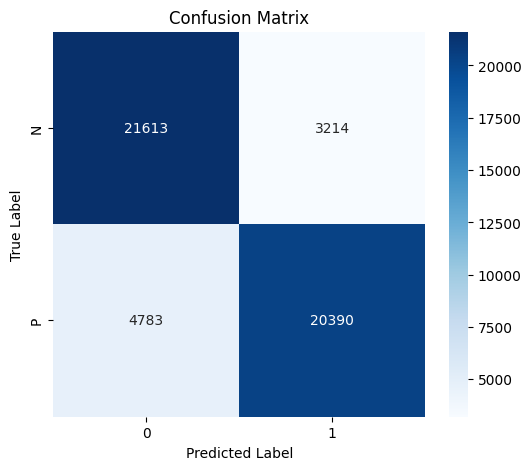

In [112]:
okt_predict = model.predict(X_test)
okt_predict = (okt_predict > 0.5).astype(int).squeeze()
print("Accuracy: ", accuracy_score(y_test, okt_predict))
print("Classification Rep: \n", classification_report(y_test,okt_predict))

cm_bpe = confusion_matrix(y_test, okt_predict)
# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm_bpe, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['N', 'P'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 회고: 중간중간에 결과 요약 있음

토크나이저마다 살짝의 변형이 있고, 각 어휘의 변형에 따라서 토큰을 다르게 잡기는 하지만 기본적으로 성능에 유의미한 편차가 존재하지는 않는 듯?

SentencePiece 안에서도 unigram (n=2) vs BPE의 맞대결이 있었고

sentencepiece와 otk의 싸움이 있었는데 놀랍게도 성능이 거의 다 같음 .. 

마음에 안 드는 건 이제 신경망을 경량화하고 오버피팅을 방지하는 여러 기법을 적용하였음에도 불구하고, 대부분 학습 초기에 바로 오버피팅에 들어갔다는 것. 

모델을 더 경량화할 경우 피쳐를 충분히 학습 못 할 가능성이 존재하지 않을까? 에 대한 고민이 생긴다. 심지어 지금도 이미 그럴지도 모름.